# Description

* Quality control on MiSeq run data
  * post-merging
  * post-demultiplexing
  
This notebook is built off Buckley lab SOP with additional ITS specific pipeline components from Steven Higgins

# Setting variables

In [3]:
import os

## What directory do you want to work in and keep all subsequent files in?
baseDir = '/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/'

## What do you want to call the sub-directory that contains the QC files
workDir = os.path.join(baseDir, 'QC')

## What is your sequence file called?
seqFile = os.path.join(baseDir, 'merge_demult', 'pear_merged_hemp_ITS.assembled.dmult.fastq')

## Where are your sequencing adapters for cutadapt?
adaptFile = '/home/sam/notebooks/hemp_microbiome/data/buckley_lab_cutadapt_primers.txt'

## Where do you want your temporary directory?
tempDir = './tmp'

# How many processors do you want to use for multi-processing
nprocs = 10

# What is your maximum expected error threshold?
maxee = 1

# Init

In [4]:
import re
import pandas as pd

In [5]:
%load_ext rpy2.ipython
#%load_ext pushnote

In [6]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:dplyr’:

    combine


  warnings.warn(x, RRuntimeWarning)


In [7]:
## Go into your QC directory. If it doesnt exist, this command will also generate it/
if not os.path.isdir(workDir):
    print ("QC directory does not exist. Making in now")
    os.makedirs(workDir)
%cd $workDir

QC directory does not exist. Making in now
/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/QC


In [8]:
# symlinking demult seq file into QC
tmp = os.path.split(seqFile)[1]
tmp = os.path.join(workDir, tmp)
if not os.path.isfile(tmp):
    os.symlink(seqFile, tmp)
else:
    print ('File exists: {}'.format(seqFile))


# Remove adapter/primer contaminants - __DONT RUN__


This step makes sure that all you have in your sequence is the ITS region. This section is a modified version of code from Steve Higgins.

In [7]:
# Function to parse the adapters file input to cutadapt
def adapt(adf):
    vlis = []
    for i in range(len(adf)):
        l = adf[i].rstrip()
        vlis.append(l)
    return vlis

In [8]:
# Name your output
qcFile = os.path.split(seqFile)[1].replace('fastq', 'cutadapt.fastq')
qcFile

# the number of cutadapt processes to run simultaneously
steps = 5

# Read adaptor sequences
lis = adapt(open(adaptFile).readlines())

# Run cutadapt
cmdarr = 'cutadapt -n 2 -b ' + ' -b '.join(lis) + ' -O 5 --match-read-wildcards -j ' + str(nprocs) + ' -o ' + qcFile + ' ' + seqFile

print (cmdarr)
#os.system(cmdarr)

    # remove sequences that were not trimmed
    #os.system('cutadapt -n 2 -b ' + ' -b '.join(lis) + ' --discard-untrimmed --match-read-wildcards -o ' + fq + '.cutadapt ' + fq + ' 2>&1 > cutadapt.log')

cutadapt -n 2 -b AATGATACGGCGACCACCGAGATCTACACATCGTACGTATGGTAATTGTGTGCCAGCMGCCGCGGTAA -b AATGATACGGCGACCACCGAGATCTACACACTATCTGTATGGTAATTGTGTGCCAGCMGCCGCGGTAA -b AATGATACGGCGACCACCGAGATCTACACTAGCGAGTTATGGTAATTGTGTGCCAGCMGCCGCGGTAA -b AATGATACGGCGACCACCGAGATCTACACCTGCGTGTTATGGTAATTGTGTGCCAGCMGCCGCGGTAA -b AATGATACGGCGACCACCGAGATCTACACTCATCGAGTATGGTAATTGTGTGCCAGCMGCCGCGGTAA -b AATGATACGGCGACCACCGAGATCTACACCGTGAGTGTATGGTAATTGTGTGCCAGCMGCCGCGGTAA -b AATGATACGGCGACCACCGAGATCTACACGGATATCTTATGGTAATTGTGTGCCAGCMGCCGCGGTAA -b AATGATACGGCGACCACCGAGATCTACACGACACCGTTATGGTAATTGTGTGCCAGCMGCCGCGGTAA -b AATGATACGGCGACCACCGAGATCTACACCTACTATATATGGTAATTGTGTGCCAGCMGCCGCGGTAA -b AATGATACGGCGACCACCGAGATCTACACCGTTACTATATGGTAATTGTGTGCCAGCMGCCGCGGTAA -b AATGATACGGCGACCACCGAGATCTACACAGAGTCACTATGGTAATTGTGTGCCAGCMGCCGCGGTAA -b AATGATACGGCGACCACCGAGATCTACACTACGAGACTATGGTAATTGTGTGCCAGCMGCCGCGGTAA -b AATGATACGGCGACCACCGAGATCTACACACGTCTCGTATGGTAATTGTGTGCCAGCMGCCGCGGTAA -b AATGATACGGCGACCACCGAGATCTACACTCGACGAGTATGGTAATT

# Merged read quality filtering

## Discard sequences that exceed max expected error theshold

In [12]:
qcFile = os.path.splitext(seqFile)[0] + '_maxee{}.fasta'.format(maxee)
qcFile = os.path.join(workDir, qcFile)
print (qcFile)

/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/merge_demult/pear_merged_hemp_ITS.assembled.dmult_maxee1.fasta


In [13]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

mkdir /home/sam/tmp/tmpdir1
trap "rm -r /home/sam/tmp/tmpdir1" 1 2 3 15
split -d -l 2000000 $1 /home/sam/tmp/tmpdir1/Block

mkdir /home/sam/tmp/tmpdir2
trap "rm -r /home/sam/tmp/tmpdir2" 1 2 3 15
ls /home/sam/tmp/tmpdir1/Block?? | parallel --gnu -j $2 -k "usearch -fastq_filter {} -fastq_maxee $3 \
-fastaout /home/sam/tmp/tmpdir2/{#}.fasta >/dev/null 2>&1 && cat /home/sam/tmp/tmpdir2/{#}.fasta" > $4
rm -r /home/sam/tmp/tmpdir2 /home/sam/tmp/tmpdir1

In [14]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

printf "Max expected error cutoff: "
echo $3

printf "Number of sequence pre-filter: "
grep -c "orig_name=" $1

printf "Number of sequences post-filter: "
grep -c ">" $4

echo '' 
head -n 8 $4

Max expected error cutoff: 1
Number of sequence pre-filter: 10581210
Number of sequences post-filter: 10261702

>3-4-L_1 orig_name=M02465:428:000000000-BND2L:1:2106:14752:1731
TTGTCGAAACCTGCAACAGCAGAACGACCCGTGAACACGTTTTAAACAGCTTGGGCGGGCGAGAGGAGCTTGCTCCTTGG
ACCCGCCCGCACCTGCTGGGAGAAATCTCGGCGGGCTAACGAACCCCGGCGCAATCTGCGCCAAGGAACAAGAAAAGATT
ATCGCGTGGCTCGTGCGGTGGCCCGGAGACGGTGTCCGCCAATCGAGATGCGTGTTTATCGAAATGTCTAAACGACTCTC
GGCAACGGATATCTCGGCTCTCGG
>3-1-RT_3 orig_name=M02465:428:000000000-BND2L:1:2106:11478:1736
TTGTCGAAACCTGCAACAGCAGAACGACCCGTGAACACGTTTTAAACAGCTTGGGCGGGCGAGAGGAGCTTGCTCCTTGG
ACCCGCCCGCACCTGCTGGGAGAAATCTCGGCGGGCTAACGAACCCCGGCGCAATCTGCGCCAAGGAACAAGAAAAGATT


## Remove seqs with 'N' characters

In [15]:
qcFile2 = os.path.splitext(qcFile)[0] + '_noN.fasta'
qcFile2

'/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/merge_demult/pear_merged_hemp_ITS.assembled.dmult_maxee1_noN.fasta'

In [16]:
%%bash -s "$qcFile" "$qcFile2"

bioawk -c fastx '{if ($seq !~ /N/){print ">" $name " " $4 "\n" $seq}}' $1 > $2

printf "Number of sequence pre-filter: "
grep -c ">" $1

printf "Number of sequences post-filter: "
grep -c ">" $2

Number of sequence pre-filter: 10261702
Number of sequences post-filter: 10261702


## Identify unique sequences

In [17]:
%%bash -s "$qcFile2"
# making mothur group file

perl -ne 'if(/^>/){ s/>(.+)(_\d+) .+/$1$2\t$1/; print;}' $1 > group_file.txt
head group_file.txt

3-4-L_1	3-4-L
3-1-RT_3	3-1-RT
2-3-L_4	2-3-L
2-5-RT_6	2-5-RT
1-4-RT_7	1-4-RT
2-2-F_8	2-2-F
6-3-RT_9	6-3-RT
M5-1_10	M5-1
F2-1_11	F2-1
1-1-RT_12	1-1-RT


In [18]:
! head -n 200 group_file.txt

3-4-L_1	3-4-L
3-1-RT_3	3-1-RT
2-3-L_4	2-3-L
2-5-RT_6	2-5-RT
1-4-RT_7	1-4-RT
2-2-F_8	2-2-F
6-3-RT_9	6-3-RT
M5-1_10	M5-1
F2-1_11	F2-1
1-1-RT_12	1-1-RT
3-1-RT_13	3-1-RT
3-4-L_14	3-4-L
F4-3_15	F4-3
3-1-RT_16	3-1-RT
6-3-RT_20	6-3-RT
3-1-RT_21	3-1-RT
3-1-RT_22	3-1-RT
5-5-RT_23	5-5-RT
5-5-RT_24	5-5-RT
M2-1_25	M2-1
5-2-F_26	5-2-F
3-1-RT_27	3-1-RT
1-3-RT_28	1-3-RT
1-5-RT_30	1-5-RT
4-1-RS_32	4-1-RS
4-4-F_34	4-4-F
1-4-RT_35	1-4-RT
4-1-RS_39	4-1-RS
F1-2_40	F1-2
3-3-RT_41	3-3-RT
6-5-RT_43	6-5-RT
4-1-RT_44	4-1-RT
1-5-L_45	1-5-L
6-1-F_46	6-1-F
3-3-RT_47	3-3-RT
1-5-F_48	1-5-F
4-1-RT_49	4-1-RT
3-1-RT_50	3-1-RT
M5-3_52	M5-3
2-2-F_53	2-2-F
5-4-L_54	5-4-L
5-5-L_55	5-5-L
4-5-F_57	4-5-F
4-1-F_58	4-1-F
F4-1_59	F4-1
3-4-F_60	3-4-F
3-5-F_61	3-5-F
4-5-RT_62	4-5-RT
3-5-F_63	3-5-F
3-1-F_64	3-1-F
2-1-F_66	2-1-F
2-1-F_67	2-1-F
2-2-RT_68	2-2-RT
6-1-RT_69	6-1-RT
4-4-RT_70	4-4-RT
2-4-L_71	2-4-L
4-4-F_72	4-4-F
3-1-RT_73	3-1-RT
4-2-F_74	4-2-F
5-2-L_75	5-2-L
3-1-RT_76	3-1-RT
F3-2_78	F3-2
2-1-RT_79	2-1-RT
4-1-RT_80	4-1-RT

In [19]:
# unique sequences
cmd = 'mothur "#unique.seqs(fasta={})"'.format(qcFile2)
!$cmd | tail -n 30

10240000	1149039
10241000	1149150
10242000	1149277
10243000	1149402
10244000	1149514
10245000	1149625
10246000	1149742
10247000	1149854
10248000	1149979
10249000	1150077
10250000	1150195
10251000	1150325
10252000	1150462
10253000	1150575
10254000	1150701
10255000	1150835
10256000	1150953
10257000	1151090
10258000	1151221
10259000	1151367
10260000	1151532
10261000	1151686
10261702	1151873

Output File Names: 
/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/merge_demult/pear_merged_hemp_ITS.assembled.dmult_maxee1_noN.names
/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/merge_demult/pear_merged_hemp_ITS.assembled.dmult_maxee1_noN.unique.fasta


mothur > quit()


In [20]:
qcFile3 = os.path.splitext(qcFile2)[0] + '.unique.fasta'
n_uniq = !grep -c ">" $qcFile3
print ('Number of unique sequences: {}'.format(n_uniq[0]))

Number of unique sequences: 1151873


In [21]:
# name file produced by unique.seqs()
nameFile = os.path.splitext(qcFile2)[0] + '.names'
!ls -thlc $nameFile

-rw-rw-r-- 1 sam sam 157M May 25 12:12 /home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/merge_demult/pear_merged_hemp_ITS.assembled.dmult_maxee1_noN.names


In [22]:
# Get summary data on sequences
cmd = 'mothur "#summary.seqs(fasta={}, processors={}, name={})"'.format(qcFile3, nprocs, nameFile)
!$cmd | tail -n 20

Using 10 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	1	50	50	0	2	1
2.5%-tile:	1	138	138	0	4	256543
25%-tile:	1	264	264	0	4	2565426
Median: 	1	264	264	0	4	5130852
75%-tile:	1	264	264	0	4	7696277
97.5%-tile:	1	264	264	0	6	10005160
Maximum:	1	432	432	0	37	10261702
Mean:	1	246.912	246.912	0	4.1285
# of unique seqs:	1151873
total # of seqs:	10261702

Output File Names: 
/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/merge_demult/pear_merged_hemp_ITS.assembled.dmult_maxee1_noN.unique.summary

It took 5 secs to summarize 10261702 sequences.

mothur > quit()


## Removing homopolymers (> 8)

In [23]:
cmd = """mothur '#screen.seqs(fasta={},\
    processors={},\
    name={},\
    group={},\
    maxhomop=8)'""".format(qcFile3, nprocs, nameFile, 'group_file.txt')
!$cmd | tail -n 30

Processing sequence: 111700
Processing sequence: 111800
Processing sequence: 111900
Processing sequence: 112000
Processing sequence: 112100
Processing sequence: 112200
Processing sequence: 112300
Processing sequence: 112400
Processing sequence: 112500
Processing sequence: 112600
Processing sequence: 112700
Processing sequence: 112800
Processing sequence: 112900
Processing sequence: 113000
Processing sequence: 113100
Processing sequence: 113200
Processing sequence: 113300
Processing sequence: 113400
Processing sequence: 113491

Output File Names: 
/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/merge_demult/pear_merged_hemp_ITS.assembled.dmult_maxee1_noN.unique.good.fasta
/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/merge_demult/pear_merged_hemp_ITS.assembled.dmult_maxee1_noN.unique.bad.accnos
/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/merge_demult/pear_merged_hemp_ITS.assembled.dmult_maxee1_noN.good.names
/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/merge_demult/grou

In [24]:
qcFile4 = os.path.splitext(qcFile3)[0] + '.good.fasta'
ret = !grep -c ">" $qcFile4
print ('Number of sequences post-filter: {}'.format(ret[0]))

Number of sequences post-filter: 1147070


In [25]:
## Get summary
cmd = 'mothur "#summary.seqs(fasta={}, processors={})"'.format(qcFile4, nprocs)
!$cmd | tail -n 20


Using 10 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	1	50	50	0	2	1
2.5%-tile:	1	73	73	0	3	28677
25%-tile:	1	177	177	0	4	286768
Median: 	1	235	235	0	4	573536
75%-tile:	1	264	264	0	5	860303
97.5%-tile:	1	296	296	0	6	1118394
Maximum:	1	432	432	0	8	1147070
Mean:	1	217.388	217.388	0	4.33738
# of Seqs:	1147070

Output File Names: 
/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/merge_demult/pear_merged_hemp_ITS.assembled.dmult_maxee1_noN.unique.good.summary

It took 2 secs to summarize 1147070 sequences.

mothur > quit()


## Deunique seqs

In [26]:
cmd = 'mothur "#deunique.seqs(fasta={}, name={})"'.format(qcFile4, nameFile)
!$cmd | tail -n 30

mothur v.1.39.5
Last updated: 3/20/2017

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

For questions and analysis support, please visit our forum at https://www.mothur.org/forum

Type 'quit()' to exit program



mothur > deunique.seqs(fasta=/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/merge_demult/pear_merged_hemp_ITS.assembled.dmult_maxee1_noN.unique.good.fasta, name=/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/merge_demult/pear_merged_hemp_ITS.assembled.dmult_maxee1_noN.names)

Output File Names: 
/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/merge_demult/pear_merged_

### Final QC-ed file

In [27]:
qcFile5 = os.path.splitext(qcFile4)[0] + '.redundant.fasta'
qcFinal = 'finalQC.fasta'
!perl -pe 's/[-.]//g if ! /^>/' $qcFile5 > $qcFinal

In [28]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={})"'.format(qcFinal, nprocs)
!$cmd | tail -n 20


Using 10 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	1	50	50	0	2	1
2.5%-tile:	1	138	138	0	4	256305
25%-tile:	1	264	264	0	4	2563047
Median: 	1	264	264	0	4	5126094
75%-tile:	1	264	264	0	4	7689141
97.5%-tile:	1	264	264	0	6	9995883
Maximum:	1	432	432	0	8	10252187
Mean:	1	246.961	246.961	0	4.12339
# of Seqs:	10252187

Output File Names: 
finalQC.summary

It took 13 secs to summarize 10252187 sequences.

mothur > quit()


In [29]:
!head -n 6 $qcFinal

>3-4-L_1
TTGTCGAAACCTGCAACAGCAGAACGACCCGTGAACACGTTTTAAACAGCTTGGGCGGGCGAGAGGAGCTTGCTCCTTGGACCCGCCCGCACCTGCTGGGAGAAATCTCGGCGGGCTAACGAACCCCGGCGCAATCTGCGCCAAGGAACAAGAAAAGATTATCGCGTGGCTCGTGCGGTGGCCCGGAGACGGTGTCCGCCAATCGAGATGCGTGTTTATCGAAATGTCTAAACGACTCTCGGCAACGGATATCTCGGCTCTCGG
>F4-1_59
TTGTCGAAACCTGCAACAGCAGAACGACCCGTGAACACGTTTTAAACAGCTTGGGCGGGCGAGAGGAGCTTGCTCCTTGGACCCGCCCGCACCTGCTGGGAGAAATCTCGGCGGGCTAACGAACCCCGGCGCAATCTGCGCCAAGGAACAAGAAAAGATTATCGCGTGGCTCGTGCGGTGGCCCGGAGACGGTGTCCGCCAATCGAGATGCGTGTTTATCGAAATGTCTAAACGACTCTCGGCAACGGATATCTCGGCTCTCGG
>5-5-RT_566157
TTGTCGAAACCTGCAACAGCAGAACGACCCGTGAACACGTTTTAAACAGCTTGGGCGGGCGAGAGGAGCTTGCTCCTTGGACCCGCCCGCACCTGCTGGGAGAAATCTCGGCGGGCTAACGAACCCCGGCGCAATCTGCGCCAAGGAACAAGAAAAGATTATCGCGTGGCTCGTGCGGTGGCCCGGAGACGGTGTCCGCCAATCGAGATGCGTGTTTATCGAAATGTCTAAACGACTCTCGGCAACGGATATCTCGGCTCTCGG


# Keep just ITS

There still may be some parts of these sequences that are part of the 5S or 18S sequences. We just want the ITS1 sequence so lets use ITSx to keep just ITS. Again this is modified from Steve Higgins' code.

In [8]:
## generate file names
qcFinal = 'finalQC.fasta'
qcFinal_file = os.path.join(workDir, qcFinal)
print (qcFinal_file)

ITSx_output = os.path.split(qcFinal)[1].replace('fasta', 'ITSx.fasta')
ITSx_output = os.path.join(workDir, ITSx_output)
print (ITSx_output)

/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/QC/finalQC.fasta
/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/QC/finalQC.ITSx.fasta


ITSx takes for __ever__ to run. According to http://geoffreyzahn.com/getting-started-with-qiime-for-fungal-its-cleaning-its-reads-and-picking-otus/, they suggest splitting the fasta into smaller fasta files and running those separately. Lets try that here.

In [10]:
%%bash -i qcFinal_file
mkdir ITSx_run
cd ITSx_run
fasta-splitter.pl --n-parts 10 $1

bash: cannot set terminal process group (76441): Inappropriate ioctl for device
bash: no job control in this shell
bash: qcFinal_file: No such file or directory


In [44]:
## Run ITSx command from your terminal
cmdarr = 'ITSx -i ' + qcFinal_file + ' -o ITSx.output --save_regions ITS1 --cpu 5 --preserve T --reset T -t all --heuristics --table T -E 0.01 --detailed_results T'
print (cmdarr)


ITSx -i /home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/QC/finalQC.fasta -o ITSx.output --save_regions ITS1 --cpu 5 --preserve T --reset T -t all --heuristics --table T -E 0.01 --detailed_results T


Wait for the previous step to be run in the terminal

In [ ]:
## Run ITSx command keeping just fungi only
cmdarr = 'ITSx -i ' + qcFinal_file + ' -o finalQC.ITSx.fungi.output --save_regions ITS1 --cpu 5 --preserve T -t F --table T -E 0.01 --detailed_results T'
print (cmdarr)
os.system(cmdarr)

## Summary of number of seqs per sample

In [30]:
qcFinal = '/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/QC/finalQC.fasta'

In [31]:
!grep -c ">" $qcFinal

10252187


In [32]:
re1 = re.compile('_[0-9]+$')

qcFinalSum = os.path.splitext(qcFinal)[0] + '.summary'

samp_count = dict()
with open(qcFinalSum, 'r') as inFH:
    for line in inFH:
        if line.startswith('seqname'):
            continue
        line = line.rstrip().split('\t')
        line[0] = re.sub(re1, '', line[0])
        try:
            samp_count[line[0]] += 1
        except KeyError:
            samp_count[line[0]] = 1

In [33]:
# converting to dataframe
df_seq_cnt = pd.DataFrame.from_dict(samp_count, orient='index')
df_seq_cnt.index.name = 'Sample'
df_seq_cnt.reset_index(inplace=True)
df_seq_cnt.columns = ['Sample', 'seq_count']
df_seq_cnt

,Sample,seq_count
0,3-4-L,72759
1,F4-1,49151
2,5-5-RT,54540
3,M2-1,102468
4,3-4-BS,19551
5,6-1-L,38388
6,3-4-F,99421
7,F3-1,106897
8,4-3-BS,28182
9,3-1-RT,297519


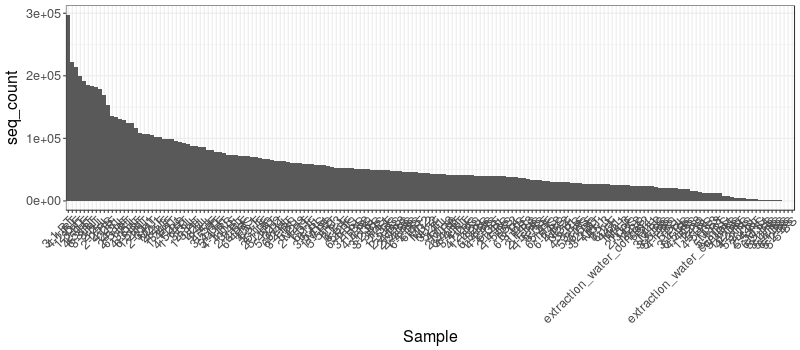

In [34]:
%%R -i df_seq_cnt -w 800 -h 350
# plotting all

df_seq_cnt$seq_count = as.numeric(df_seq_cnt$seq_count)


df_seq_cnt = df_seq_cnt %>% 
    #mutate(H2O = grepl('_F0$', Sample)) %>%
    mutate(rank = min_rank(seq_count)) %>%
    arrange(desc(rank))

df_seq_cnt$Sample = factor(df_seq_cnt$Sample, levels=df_seq_cnt$Sample)

ggplot(df_seq_cnt, aes(Sample, seq_count)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [35]:
%%R
df_seq_cnt[df_seq_cnt$seq_count < 10000,]

                       Sample seq_count rank
165                    5-3-BS      8616   18
166 extraction_water_control1      7447   17
167                    5-4-RS      5457   16
168                    1-2-BS      5227   15
169                    4-2-RT      4183   14
170                    4-3-RS      4079   13
171                    5-2-RS      3426   12
172                     6-2-L      2753   11
173                    2-4-RT      2348   10
174                    5-5-RS      1871    9
175                      M3-1      1303    8
176                    6-5-BS      1103    7
177                    5-1-RS      1035    6
178                    3-4-RS       978    5
179                    5-4-BS       904    4
180                    6-1-BS       474    3
181                    5-2-BS       374    2
182                    5-5-BS       130    1
